In [3]:
import sys
import torch
import numpy as np
import pickle as pkl
import os
import copy 

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt
sys.path.append('../../../')


from experiments.supervised.product_manifold.script import product_manifold, plot_networks
from riemannian_geometry.computations.pullback_metric import pullback_ricci_tensor, pullback_all_metrics
from models.supervised.mlp.model import MLP

models_path = "../../../models/supervised/mlp/saved_models"


In [4]:
np.random.seed(2)
torch.manual_seed(2)

In [5]:
size = "vanilla"
mode = "blobs"
epoch = 199
model = MLP(2,7,4,4)
with open(f'{models_path}/{size}/mlp_{mode}/dataset.pkl', 'rb') as f:
	dataset = pkl.load(f)

full_path = f'{models_path}/{size}/mlp_{mode}/model_{epoch}.pth'
model.load_state_dict(torch.load(full_path))
if size == "overfit":
	model.num_layers -= 1
	model.layers = model.layers[:-1]
model.eval()


MLP(
  (layers): ModuleList(
    (0): Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=2, out_features=4, bias=True)
    )
    (1-5): 5 x Layer(
      (act_func): Tanh()
      (linear_map): Linear(in_features=4, out_features=4, bias=True)
    )
    (6): Layer(
      (act_func): Sigmoid()
      (linear_map): Linear(in_features=4, out_features=4, bias=True)
    )
  )
)

In [26]:
N=50
wrt = "layer_wise"
sigma = 0.05

X = torch.from_numpy(dataset.X).float()
labels = dataset.y


model.forward(X, save_activations=True)

activations = model.get_activations()
activations_np = [a.detach().numpy() for a in activations]

#g_inv, Ricci, surface = pullback_ricci_tensor(model, activations, N, wrt=wrt, method="manifold", sigma=sigma, normalised=False)
g, dg, ddg, surface = pullback_all_metrics(model, activations, N, wrt=wrt, method="manifold", sigma=sigma, normalised=False)


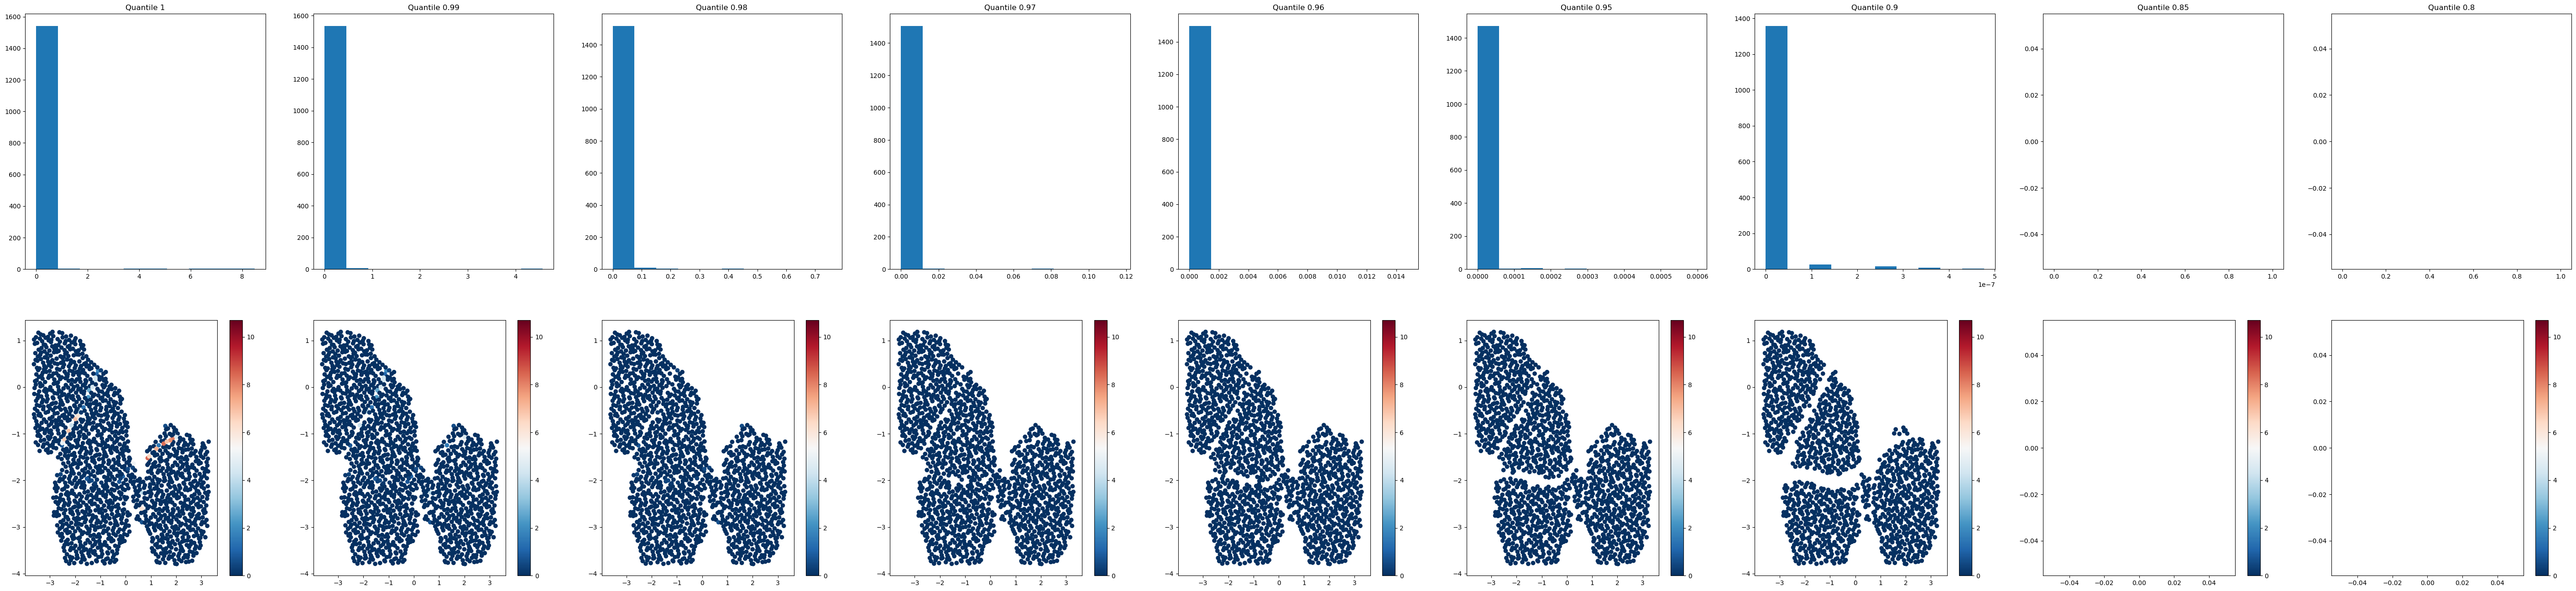

In [11]:
layer = 0

surface_ = surface[layer].copy()
activations_np_ = activations_np[layer].copy()
g_ = g[layer].copy()
V = np.linalg.det(g_)
V = np.log(np.abs(V) + 1)
#V = np.einsum('nij, njk -> n', g_inv[layer], Ricci[layer])
#V = np.sign(V)*np.log(np.abs(V) + 1)
components_pin, graphs_pin, removed_nodes, quantiles = product_manifold(surface_, V, plot=True, size=size, mode=mode, use_pin=False)


In [ ]:
import matplotlib.pyplot as plt
COLOR = plt.scatter(surface_[:, 0], surface_[:, 1], c=V, vmin=np.min(V), vmax=np.max(V), cmap="coolwarm")
plt.scatter(activations_np_[:, 0], activations_np_[:, 1], c=dataset.y, vmin=0, vmax=np.max(dataset.y), cmap="viridis")
plt.colorbar(COLOR)
plt.show()

In [ ]:
import copy
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import heapq


def construct_knn_graph(points, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    graph = {}  # Initialize an empty graph
    edge_distances = {}
    for i, neighbors in enumerate(indices):
        graph[i] = set(neighbors[1:])
        for j, dist in zip(neighbors[1:], distances[i][1:]):
            edge_distances[(i, j)] = dist
    return graph, edge_distances

def assign_node_weights(graph, V):
    node_weights = {}
    for node, neighbors in graph.items():
        weight = np.max([np.abs(V[node]), np.max(np.abs(V[list(neighbors)]))])
        weight = np.round(weight, 5)
        node_weights[node] = weight
    return node_weights

def assign_edge_weights(graph, edge_distances):
    edge_weights = {}
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            weight = np.max([np.abs(V[node]), np.abs(V[neighbor])])
            weight = np.round(weight, 5)
            eucl_dist = edge_distances[(node, neighbor)]
            edge_weights[(node, neighbor)] = {'weight': eucl_dist}
    return edge_weights

def get_knn_graph(surface, min_components, max_K=None, verbose=False):
    if max_K is None:
        max_K = np.sqrt(len(surface)).astype(int)
    for k in range(2, max_K):
        knn_graph, edge_distances = construct_knn_graph(surface, k=k)


        G = nx.Graph()

        for u, nghbrs in knn_graph.items():
            for v in nghbrs:
                G.add_edge(u, v)
                G.add_edge(v, u)
        sccs = list(nx.connected_components(G))
        print(len(sccs))
        if verbose:
            print(f"K={k} -> {len(sccs)}")
        if len(sccs) <= min_components:
            break
        if verbose:
            print(f"Nodes remaining: {sorted(sccs, key=lambda x: len(x))[0]}")
    return knn_graph, edge_distances

def a_star_search(G, start, goal):
    # Initialize the priority queue with the start node and its f value (f = g + h)
    open_queue = [(G.nodes[start].get('potential', 0), start, 0)]  # (f_value, node, g_value)
    # Dictionary to store the best g_value for each visited node
    g_values = {start: 0}
    # Dictionary to store the parent of each node (used for reconstructing the path)
    came_from = {start: None}
    
    counter = 0
    while open_queue:
        # Pop the node with the smallest f_value
        _, current, current_g = heapq.heappop(open_queue)
        
        # Goal reached, reconstruct and return path
        if current == goal:
            path = []
            while current is not None:
                path.append(current)
                current = came_from[current]
            return path[::-1], counter
        
        # Explore neighbors
        for neighbor, edge_data in G[current].items():
            tentative_g = current_g + edge_data.get('weight', 1)
            
            # If a better path to this neighbor is found, update its g_value and f_value
            if tentative_g < g_values.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_values[neighbor] = tentative_g
                f_value = tentative_g + G.nodes[neighbor].get('potential', 0)
                heapq.heappush(open_queue, (f_value, neighbor, tentative_g))
        counter += f_value                
    # If the loop completes, then there is no path from start to goal
    return None, None


In [ ]:
graph, edge_distance = get_knn_graph(surface_, min_components=4, verbose=False)
G = nx.Graph()
edge_weights = assign_edge_weights(graph, edge_distance)
G.add_edges_from(edge_weights.keys())
nx.set_edge_attributes(G, edge_weights)

node_weights = assign_node_weights(graph, V)
nx.set_node_attributes(G, node_weights, 'weight')


In [ ]:
sccs = list(nx.connected_components(G))
sccs = sorted(sccs, key=lambda x: len(x))
print(f"Number of components: {len(sccs)}")

In [ ]:
from time import process_time
from collections import defaultdict

distance_dict_time = defaultdict(list)
weight_dict = defaultdict(list)
node_num = max(G.nodes)

for _ in range(10000):
    start = np.random.randint(0, node_num)
    end = np.random.randint(0, node_num)
    start_time = process_time()
    path, weight = a_star_search(G, start, end)
    end_time = process_time()
    distance_dict_time[len(path)].append(end_time - start_time)
    weight_dict[len(path)].append(weight)

In [ ]:
sorted_dict = {k: distance_dict_time[k] for k in sorted(distance_dict_time.keys())}
plt.scatter(list(sorted_dict.keys()), [np.mean(v) for v in sorted_dict.values()])
plt.fill_between(list(sorted_dict.keys()), [np.mean(v) - np.std(v) for v in sorted_dict.values()], [np.mean(v) + np.std(v) for v in sorted_dict.values()], alpha=0.2)
plt.xlabel("Path length")
plt.ylabel("Time (s)")
plt.title("A* search time")


In [ ]:
plt.bar(list(weight_dict.keys()), [np.mean(v) for v in weight_dict.values()])
plt.xlabel("Weighted Path")
plt.ylabel("Number of nodes visited")
plt.title("A* search nodes visited")


In [ ]:
start_node = 999
distance_dict = {}
for node in G.nodes:
    path, dist = a_star_search(G, start_node, node)
    distance_dict[node] = dist
sorted_distance_dict = {k: distance_dict[k] for k in sorted(distance_dict.keys())}

pos = {i: surface_[i] for i in range(len(surface_))}
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
col = nx.draw_networkx_nodes(G, pos=pos, node_size=10, cmap=plt.cm.viridis, node_color=list(distance_dict.values()), vmin=0, vmax=max(sorted_distance_dict.values()))
plt.scatter(surface_[start_node][0], surface_[start_node][1], s=100, c='r', marker='x')
plt.colorbar(col)
plt.title(f"A* distance from node {start_node}")
plt.axis('off')
plt.show()

In [204]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities

K = 4
indx = -1
size_cutoff = len(graphs_pin[indx].keys())//(K**2)
mapable_dict = {k: v for v, k in enumerate(graphs_pin[indx].keys())}
inv_mapable_dict = {v: k for k, v in mapable_dict.items()}
graph_dict = {mapable_dict[node]: {mapable_dict[neighbor]: {'weight': data.get('distance', 0)} for neighbor, data in neighbors.items()} for node, neighbors in graphs_pin[indx].items()}
G = nx.from_dict_of_dicts(graph_dict)

connected_components_ = sorted(nx.connected_components(G), key=len, reverse=True)
connect_components = []
removed_nodes_com_size = []
for c in connected_components_:
    if len(c) > size_cutoff:
        connect_components.append(c)
    else:
        removed_nodes_com_size.extend(c)

K_ = min(K, len(connect_components))
# Create a new graph containing only the nodes in the first K largest connected components
nodes_to_keep = set().union(*connected_components[:K_])

G_filtered = G.subgraph(nodes_to_keep)
mapable_dict_filtered = {k: v for v, k in enumerate(G_filtered.nodes)}
inv_mapable_dict_filtered = {v: k for k, v in mapable_dict_filtered.items()}

coms = list(louvain_communities(G_filtered, resolution=0.01))
com_plot = np.zeros(max(G_filtered.nodes)+1)
for i, com in enumerate(coms):
    com_plot[list(com)] = i+1
com_plot = com_plot[com_plot != 0]
# Visualize the clustering result
graph_dict = {node: {neighbor: {'weight': data.get('distance', 0)} for neighbor, data in neighbors.items()} for node, neighbors in graphs_pin[0].items()}

G_0 = nx.from_dict_of_dicts(graph_dict)
G_0 = G_0.subgraph(list(removed_nodes_com_size) + list(removed_nodes[indx]))
pos = {i: surface_[i] for i in G_0.nodes()}

ec = nx.draw_networkx_edges(G_0, pos, alpha=0.8)
nc = nx.draw_networkx_nodes(G_0, pos=pos, node_size=10, cmap=plt.cm.Accent, node_color="red")

pos = {i: surface_[inv_mapable_dict[i]] for i in G_filtered.nodes()}

ec = nx.draw_networkx_edges(G_filtered, pos, alpha=0.8)
nc = nx.draw_networkx_nodes(G_filtered, pos=pos, node_size=10, cmap=plt.cm.Accent, node_color=com_plot)
plt.scatter(activations_np_[:, 0], activations_np_[:, 1], c=labels, vmin=0, vmax=np.max(labels), cmap="viridis")
plt.title("Graph After Spectral Clustering")
plt.show()

NameError: name 'connected_components' is not defined

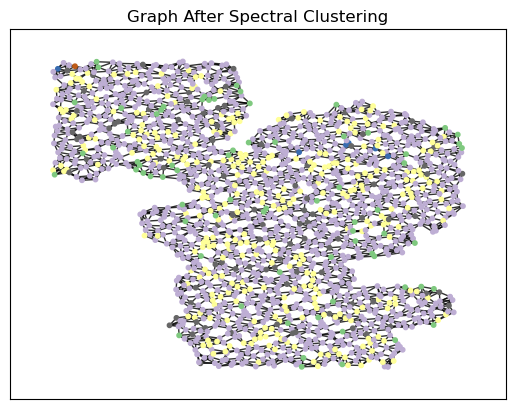

In [227]:
G = nx.from_dict_of_dicts(graphs_pin[0])
coms = list(greedy_modularity_communities(G_filtered, resolution=.1, cutoff=K, best_n=K))
coms.append(set(list(removed_nodes[indx]) + list(removed_nodes_com_size)))
pos = {i: surface_[i] for i in G.nodes()}
com_plot = np.zeros(max(G.nodes)+1)
for i, com in enumerate(coms):
    com_plot[list(com)] = i+1

ec = nx.draw_networkx_edges(G, pos, alpha=0.8)
nc = nx.draw_networkx_nodes(G, pos=pos, node_size=10, cmap=plt.cm.Accent, node_color=com_plot)
#plt.scatter(activations_np_[:, 0], activations_np_[:, 1], c=labels, vmin=0, vmax=np.max(labels), cmap="viridis")
plt.title("Graph After Spectral Clustering")
plt.show()

In [199]:

def construct_knn_graph(points, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors(points)
    graph = {}  # Initialize an empty graph
    edge_distances = {}
    for i, neighbors in enumerate(indices):
        graph[i] = set(neighbors[1:])
        for j, dist in zip(neighbors[1:], distances[i][1:]):
            edge_distances[(i, j)] = dist
    return graph, edge_distances

def assign_node_weights(graph, V, threshold):
    node_weights = {}
    for node, neighbors in graph.items():
        weight = np.max([np.abs(V[node]), np.max(np.abs(V[list(neighbors)]))]) < threshold
        weight = weight.astype(int)
        node_weights[node] = weight
    return node_weights

def assign_edge_weights(graph, edge_distances, V):
    edge_weights = {}
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            weight = np.max([np.abs(V[node]), np.abs(V[neighbor])])
            eucl_dist = edge_distances[(node, neighbor)]
            edge_weights[(node, neighbor)] = {'weight': weight*eucl_dist}
    return edge_weights

def get_knn_graph(surface, max_components, max_K=None, verbose=True):
    if max_K is None:
        max_K = np.sqrt(len(surface)).astype(int)
        
    for k in range(2, max_K):
        knn_graph, edge_distances = construct_knn_graph(surface, k=k)


        G = nx.Graph()

        for u, nghbrs in knn_graph.items():
            for v in nghbrs:
                G.add_edge(u, v)
        sccs = list(nx.connected_components(G))
        min_size = len(surface)//(len(sccs)**2)
        large_coms = [c for c in sccs if len(c) > min_size]
        if verbose:
            print(f"K={k} -> {len(large_coms)}")
        if len(large_coms) <= max_components:
            break
        if verbose:
            print(f"Nodes remaining: {sorted(sccs, key=lambda x: len(x))[0]}")
    return knn_graph, edge_distances

def get_largest_k_components(graph, K, min_size):
    sccs = sorted(list(nx.connected_components(graph)), key=lambda x: len(x), reverse=True)
    min_size = len(graph)//(K**2)
    list_ = []
    for c in sccs:
        if len(c) > min_size:
            list_.extend(c)
        else:
            break
    return list_
def iterable_graph_cut(surface, V, delta_q, max_components=None, min_size=None, max_K=None):
    if max_components is None:
        max_components = 1
    if max_K is None:
        max_K = np.sqrt(len(surface)).astype(int)
    start_q = 1
    graph, edge_distances = get_knn_graph(surface, max_components=max_components, max_K=max_K)
    G = nx.Graph()
    edge_weights = assign_edge_weights(graph, edge_distances, V)
    G.add_edges_from(edge_weights.keys())
    nx.set_edge_attributes(G, edge_weights)

    connected_components = len([c for c in list(nx.connected_components(G)) if len(c) > min_size])
    store_prev_graph = copy.deepcopy(G)
    while connected_components < max_components:
        start_q -= delta_q
        score = np.quantile(V, start_q)
        bool_ = np.argwhere(V < score).squeeze()
        subgraph_G = copy.deepcopy(G.subgraph(bool_))
        subgraph_G = nx.Graph(subgraph_G)
        articulation_pts = list(nx.articulation_points(subgraph_G))
        for pt in articulation_pts:
            subgraph_G.remove_node(pt)
        updated_bool_ = np.array(list(subgraph_G.nodes))
        components = list(nx.connected_components(subgraph_G))
        min_size = len(updated_bool_)//(max_components**2)
        connected_components = len([c for c in components if len(c) > min_size])
        print(f"Quantile: {start_q}, Connected Components: {connected_components}, Nodes Removed V: {len(bool_) - np.count_nonzero(bool_)}, Nodes Removed Articulation: {len(articulation_pts)}")

        if connected_components >= max_components:
            largest_components = get_largest_k_components(store_prev_graph, max_components, min_size)
            final_graph = store_prev_graph.subgraph(largest_components)
            return final_graph
        min_size = (len(articulation_pts) + np.sum(bool_))//(max_components**2)
        store_prev_graph = copy.deepcopy(subgraph_G)
    largest_components = get_largest_k_components(subgraph_G, max_components, min_size)
    final_graph = subgraph_G.subgraph(largest_components)
    return subgraph_G

def potential_graph_cut(surface, V, quantile, max_components=1, min_size=None, max_K=None):
    threshold = np.quantile(V, quantile)
    graph, edge_distances = get_knn_graph(surface, max_components=max_components, max_K=max_K)
    G = nx.Graph()
    edge_weights = assign_edge_weights(graph, edge_distances, V)
    G.add_edges_from(edge_weights.keys())
    nx.set_edge_attributes(G, edge_weights)

    connected_components = [[np.arange(len(surface))]]
    graphs = [nx.to_dict_of_dicts(G)]
    score = np.quantile(V, quantile)
    bool_ = np.argwhere(V < score).squeeze()
    subgraph_G = copy.deepcopy(G.subgraph(bool_))
    subgraph_G = nx.Graph(subgraph_G)
    articulation_pts = list(nx.articulation_points(subgraph_G))
    for pt in articulation_pts:
        subgraph_G.remove_node(pt)
    updated_bool_ = np.array(list(subgraph_G.nodes))
    component = list(nx.connected_components(subgraph_G))
    M = len(component)

    connected_components.append(component)
    cold_graph = nx.to_dict_of_dicts(subgraph_G.copy(), nodelist=updated_bool_)
    removed_nodes_final = articulation_pts + list(np.argwhere(V >= score).squeeze())
    hot_graph = nx.to_dict_of_dicts(G.copy(), nodelist=removed_nodes_final)
    nodes_attr = assign_node_weights(graph, V, quantile)
    nx.set_node_attributes(G, nodes_attr, 'potential')
    return cold_graph, hot_graph, G

In [200]:
indx = 0
surface_ = surface[indx].copy()
activations_np_ = activations_np[indx].copy()
g_ = g[indx].copy()
V = np.abs(np.linalg.norm(g_, axis=(1,2), ord="fro"))

In [201]:
graph_final = iterable_graph_cut(surface_, V, delta_q=0.01, max_components=4, min_size=100)

K=2 -> 468
Nodes remaining: {33, 579}
K=3 -> 13
Nodes remaining: {1140, 870, 55}
K=4 -> 0
Quantile: 0.99, Connected Components: 2, Nodes Removed V: 1, Nodes Removed Articulation: 17
Quantile: 0.98, Connected Components: 2, Nodes Removed V: 1, Nodes Removed Articulation: 35
Quantile: 0.97, Connected Components: 2, Nodes Removed V: 1, Nodes Removed Articulation: 44
Quantile: 0.96, Connected Components: 4, Nodes Removed V: 1, Nodes Removed Articulation: 59


In [264]:
from networkx.algorithms.community import greedy_modularity_communities
K=4
final_com = greedy_modularity_communities(graph_final, resolution=0.01, cutoff=K, best_n=K)

In [265]:
community_dict = {}
for i, c in enumerate(final_com):
    for node in c:
        community_dict[node] = i

In [266]:
plot_com = [community_dict[k] for k in graph_final.nodes()]

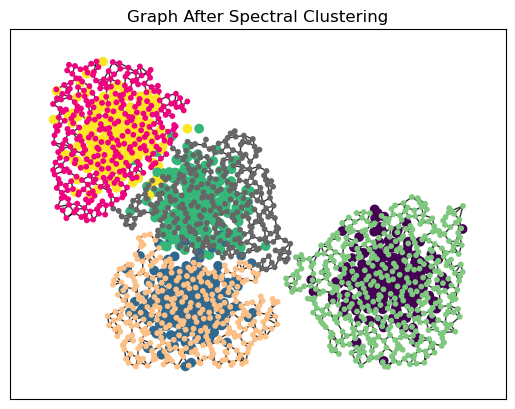

In [267]:
pos = {i: surface_[i] for i in graph_final.nodes()}
color = [betweeness[i] for i in graph_final.nodes()]
ec = nx.draw_networkx_edges(graph_final, pos, alpha=0.8)
nc = nx.draw_networkx_nodes(graph_final, pos=pos, node_size=10, cmap=plt.cm.Accent, node_color=plot_com)
plt.scatter(activations_np_[:, 0], activations_np_[:, 1], c=dataset.y, vmin=0, vmax=np.max(labels), cmap="viridis")

plt.title("Graph After Spectral Clustering")
plt.show()

/Users/maxpowers/miniconda3/envs/DL/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


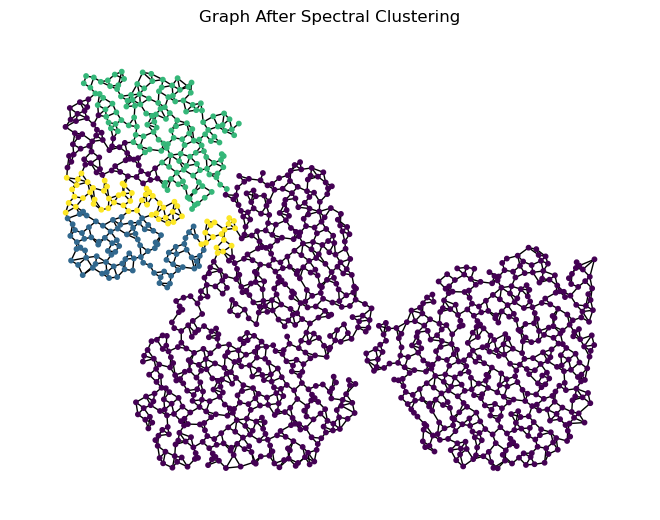

In [214]:
from sklearn.cluster import KMeans
tmp = nx.adjacency_matrix(graph_final).todense()
A = np.zeros_like(tmp)
A[tmp != 0] = 1
D = np.diag(np.sum(np.array(A), axis=1))
L = D - A

# Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Select the second smallest eigenvalue's eigenvector
K = 4
fiedler_vector = eigenvectors[:, 4]
# Apply k-means to the fiedler vector to find two clusters
kmeans = KMeans(n_clusters=4).fit(fiedler_vector.reshape(-1, 1))

# Assign labels
labels = kmeans.labels_
pos = {i: surface_[i] for i in graph_final.nodes()}
mapable_dict = {k: v for v, k in enumerate(graph_final.nodes)}
# Visualize the clustering result
nx.draw(graph_final, pos, node_color=labels, node_size=10)
plt.title("Graph After Spectral Clustering")
plt.show()


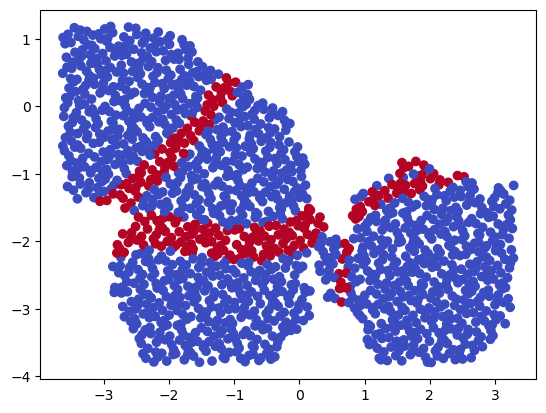

In [154]:
V_plot = np.log(np.abs(V) + 1)
plt.scatter(surface_[:, 0], surface_[:, 1], c=V > quantile, cmap="coolwarm")

In [155]:
quantile = 0.95
graph, edge_distance = get_knn_graph(surface_, max_components=4, verbose=False)
G = nx.Graph()
edge_weights = assign_edge_weights(graph, edge_distance, V)
G.add_edges_from(edge_distance)
nx.set_edge_attributes(G, edge_weights)

cold_graph, hot_graph, final_G = potential_graph_cut(surface_, V, quantile, max_components=4, max_K=None)


K=2 -> 468
Nodes remaining: {33, 579}
K=3 -> 13
Nodes remaining: {1140, 870, 55}
K=4 -> 0


In [202]:
import infomap

# Initialize Infomap
im = infomap.Infomap("--two-level --directed")

# Add nodes and edges to Infomap
for node in graph_final.nodes():
    im.add_node(node)

for u, v, data in graph_final.edges(data=True):
    weight = data.get('weight', 1.0)
    im.add_link(u, v, weight)

# Run Infomap
im.run()

  Infomap v2.7.1 starts at 2023-09-02 13:11:00
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    directed
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 62 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 1398 nodes and 2396 links...
  -> One-level codelength: 5.30073978

Trial 1/1 starting at 2023-09-02 13:11:00
Two-level compression: 59% 0.9% 1.71307439% 
Partitioned to codelength 0.162633295 + 1.95077173 = 2.113405029 in 97 modules.

=> Trial 1/1 finished in 0.015071238s with codelength 2.11340503


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [         97,           0] (sum: 97)
Per level number of leaf nodes:      [          0,        1398] (sum: 1398)
Per level average child deg

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities

coms = list(greedy_modularity_communities(graph_final, resolution=.1, cutoff=4, best_n=4))



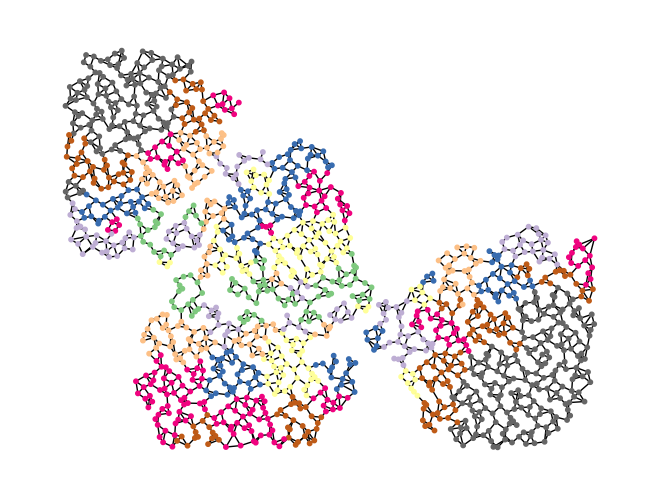

In [203]:
node_to_community = {}
for node in im.tree:
    if node.is_leaf:
        node_to_community[node.node_id] = node.module_id
pos = {i: surface_[i] for i in graph_final.nodes()}
nx.draw(graph_final, pos=pos, node_color=[node_to_community[i] for i in graph_final.nodes], cmap=plt.cm.Accent, node_size=10)
plt.show()
# Print communities

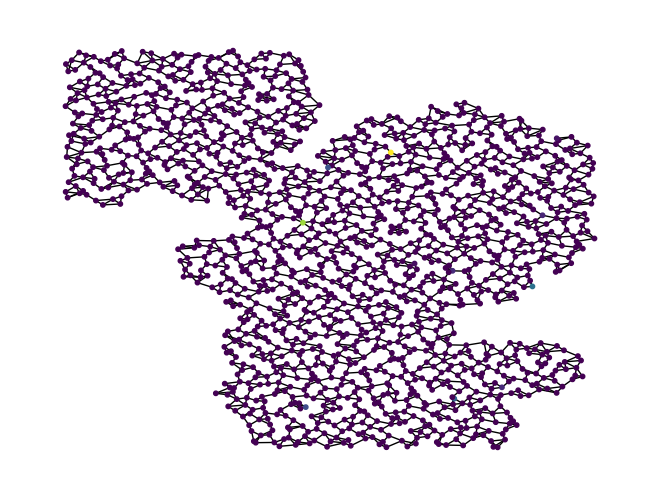

In [57]:

pos = {i: surface_[i] for i in range(len(surface_))}
nx.draw(final_G, pos=pos, node_color=[V[i] for i in final_G.nodes], cmap=plt.cm.viridis, node_size=10)
plt.show()

In [20]:
# Initialize buckets
from collections import defaultdict
buckets = defaultdict(set)
cold_nodes = list(cold_graph.keys())
hot_nodes = list(hot_graph.keys())

while len(cold_nodes) > 0:
    # Pop a node from the cold_nodes list
    node = cold_nodes.pop(0)
    
    # Create a new bucket for the node
    new_bucket_id = len(buckets)
    buckets[new_bucket_id].add(node)
    
    # Create a list to store nodes to be removed from cold_nodes
    nodes_to_remove = []
    
    # Iterate through remaining 'cold' nodes to find potential bucket members
    for other_node in cold_nodes:
        hot_count = count_hot_nodes_in_path(final_G, node, other_node, hot_nodes)
        
        if hot_count == 0:
            # If no 'hot' nodes are in the path, add to the same bucket
            buckets[new_bucket_id].add(other_node)
            nodes_to_remove.append(other_node)
            
    # Remove nodes that have been added to a bucket
    for node in nodes_to_remove:
        cold_nodes.remove(node)

buckets

1661
1544
117


AttributeError: 'dict' object has no attribute 'nodes'

In [ ]:
G[0]